## Quantifying Centone Content in Arab Andalusian Music using TF-IDF
March - 2019

In [47]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../src/')

import extraction
import model
import persistence
import reporting

In [37]:
import os
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import Counter

### Load

Load mappings Nawba mappings and recording metadata

In [4]:
data_path = '../data/'

In [59]:
# Nawba Mappings to centones
nawba_centones = persistence.load_and_parse_centones_mapping(os.path.join(data_path, 'Centones_Nawba.csv'))
# Nawba Mappings to tabs
nawba_tabs = persistence.load_and_parse_nawba_tabs(os.path.join(data_path, 'nawba_tabs.json'))

# Recording Descriptions
andalusian_description =  pd.read_json(os.path.join(data_path, 'andalusian_description.json'))

### Download

Download all scores from dunya

In [6]:
dunya_token = '<INSERT DUNYA TOKEN HERE>'
scores_path = os.path.join(data_path, 'scores/')

In [7]:
scores = persistence.download_scores(andalusian_description, dunya_token, target_folder=scores_path)

In [6]:
scores = []
scores_path = os.path.join(data_path, 'scores/')
# Some scores do not have the relevant metadata
for i, row in andalusian_description.iterrows():
    try:
        tn = row['sections'][0]['tab']['transliterated_name']
    except:
        tn = ''
    scores.append([row['mbid'], tn])

In [7]:
# Replace tab with nawba
# (mbid, nawba)
mbid_nawba = [[x[0], nawba_tabs[x[1]]] for x in scores if x[1] in nawba_tabs]

# Nawba mbid lookup
nawba_mbid_lookup = {x[0]:x[1] for x in mbid_nawba}

### Pattern Extraction

Load all scores into a stream of notes

In [8]:
notes_dict = {}
chord_mbid = []

for i,(mbid, nawba) in enumerate(mbid_nawba):
    this_score_path = os.path.join(scores_path, mbid + '.xml')
    # Fails for scores with chords
    try:
        note_stream = persistence.pattern_stream_from_score(this_score_path, 4)
        notes_dict[mbid] = note_stream
    except Exception as e:
        print('{} contains chords and wont be counted'.format(mbid))
        chord_mbid.append(mbid)

final_scores = [x for x in scores if x[0] not in chord_mbid]

notes_indices = notes_dict.keys()
notes = notes_dict.values()

2d8e2820-e4cf-4dc8-b4f1-45f8fb65de9e contains chords and wont be counted


Extract bag of patterns from each score

In [9]:
mbid_patterns = [extraction.extract_pattern_grams(nt, min_n=2, max_n=10) for nt in notes]

In [10]:
# Convert indices from mbid to Nawba
full_nawba_indices = [nawba_mbid_lookup[x] for x in notes_indices]

### TFIDF

Apply TF-IDF on corpus of bag of patterns

In [11]:
distributions = model.get_tfidf_distributions(mbid_patterns)

Average tf-idf for each pattern for each Nawba

In [12]:
frame_grouped = model.average_tfidf(distributions, full_nawba_indices)

In [35]:
frame_grouped[:5]

,nawba,pattern,tf-idf,frequency
0,Nawba_1,AA,0.000358,4038
1,Nawba_1,AAA,0.000166,2034
2,Nawba_1,AAAA,0.000078,979
3,Nawba_1,AAAAA,0.000039,447
4,Nawba_1,AAAAAA,0.000016,163


### Ground truth algorithm (Centones counter)

Apply the algorithm for each mbid store the results in a dataframe

In [14]:
df_predicted_nawba=[]
for mbid in notes_dict:
    predicted = model.count_centones(mbid,notes_dict,nawba_centones)
    df_predicted_nawba.append({'mbid': mbid, 'annotated': nawba_mbid_lookup[mbid], 'predicted': predicted})

df_predicted_nawba= pd.DataFrame(df_predicted_nawba)
df_predicted_nawba= df_predicted_nawba[['mbid','annotated','predicted']]


Plot the results (MAYBE THIS COULD BE AT THE BEGINNING OF THE 'RESULTS' SECTION)

The tab with the most number of characteristics centones and the annotations matched in:  20.80536912751678 %


<module 'matplotlib.pyplot' from '/home/miguelgc96/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

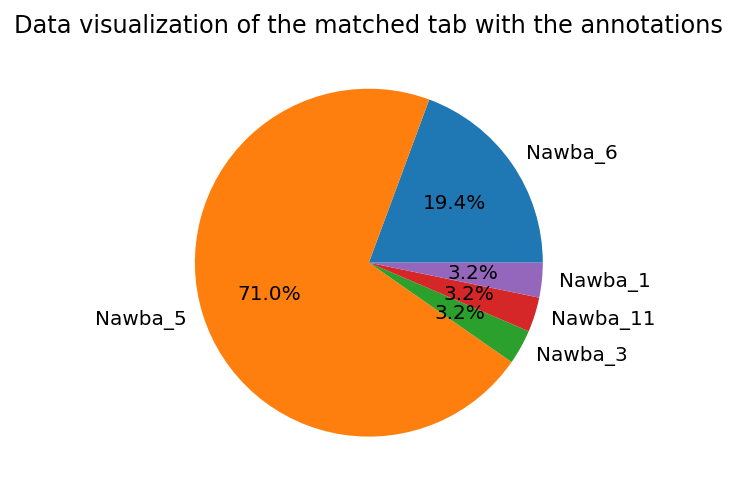

In [15]:
reporting.plot_centones_per_nawba(df_predicted_nawba)

<module 'matplotlib.pyplot' from '/home/miguelgc96/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

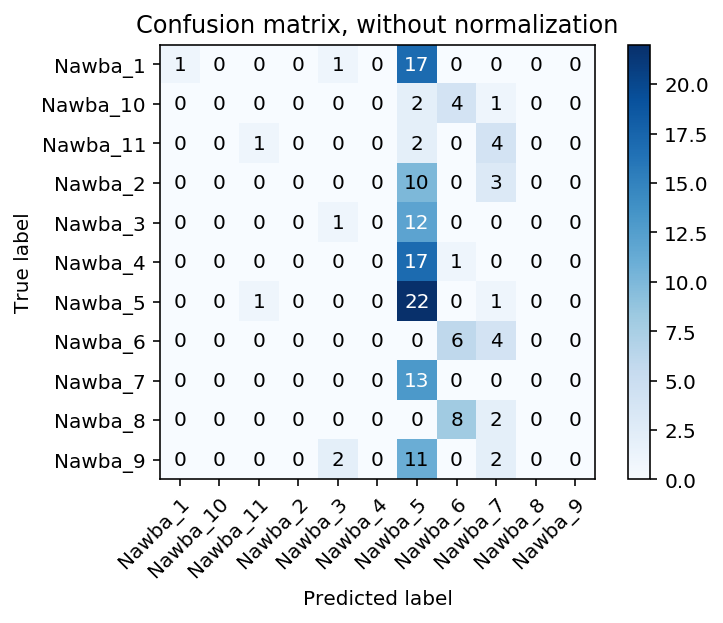

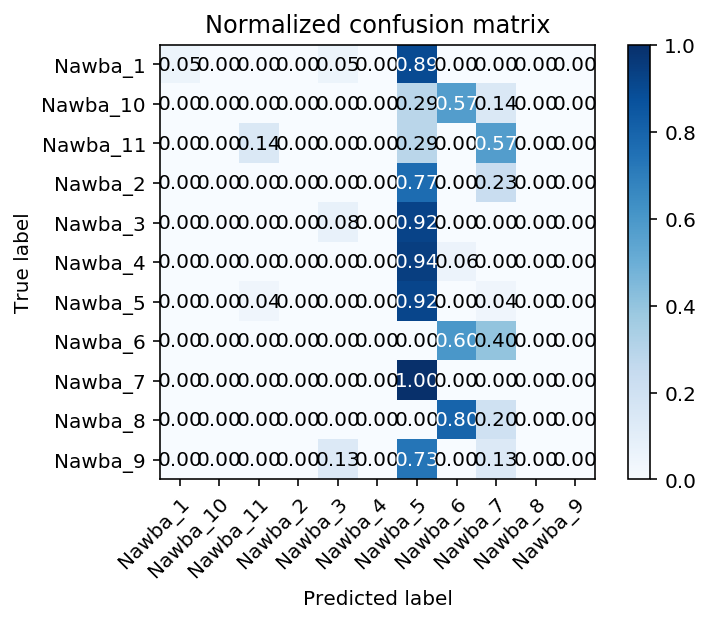

In [16]:
annotated = df_predicted_nawba['annotated'].tolist()
predicted = df_predicted_nawba['predicted'].tolist()
np.set_printoptions(precision=2)

reporting.plot_confusion_matrix(annotated, predicted,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
reporting.plot_confusion_matrix(annotated, predicted, normalize=True,
                      title='Normalized confusion matrix')

### Results

Plot analysis results

In [36]:
# Initialise Nawba number to plot
i = 1

Repeatedly run these cells to iterate through all Nawbas

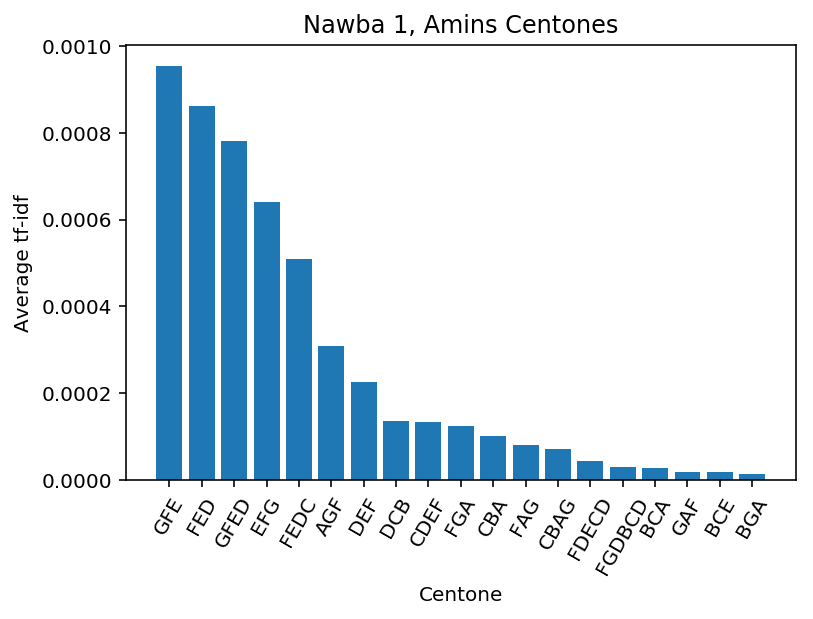

In [37]:
nawba = 'Nawba_{}'.format(i)
reporting.get_amins_plot(frame_grouped, nawba, nawba_centones)
i += 1
if i > len(set(nawba_centones.keys())):
    i = 1

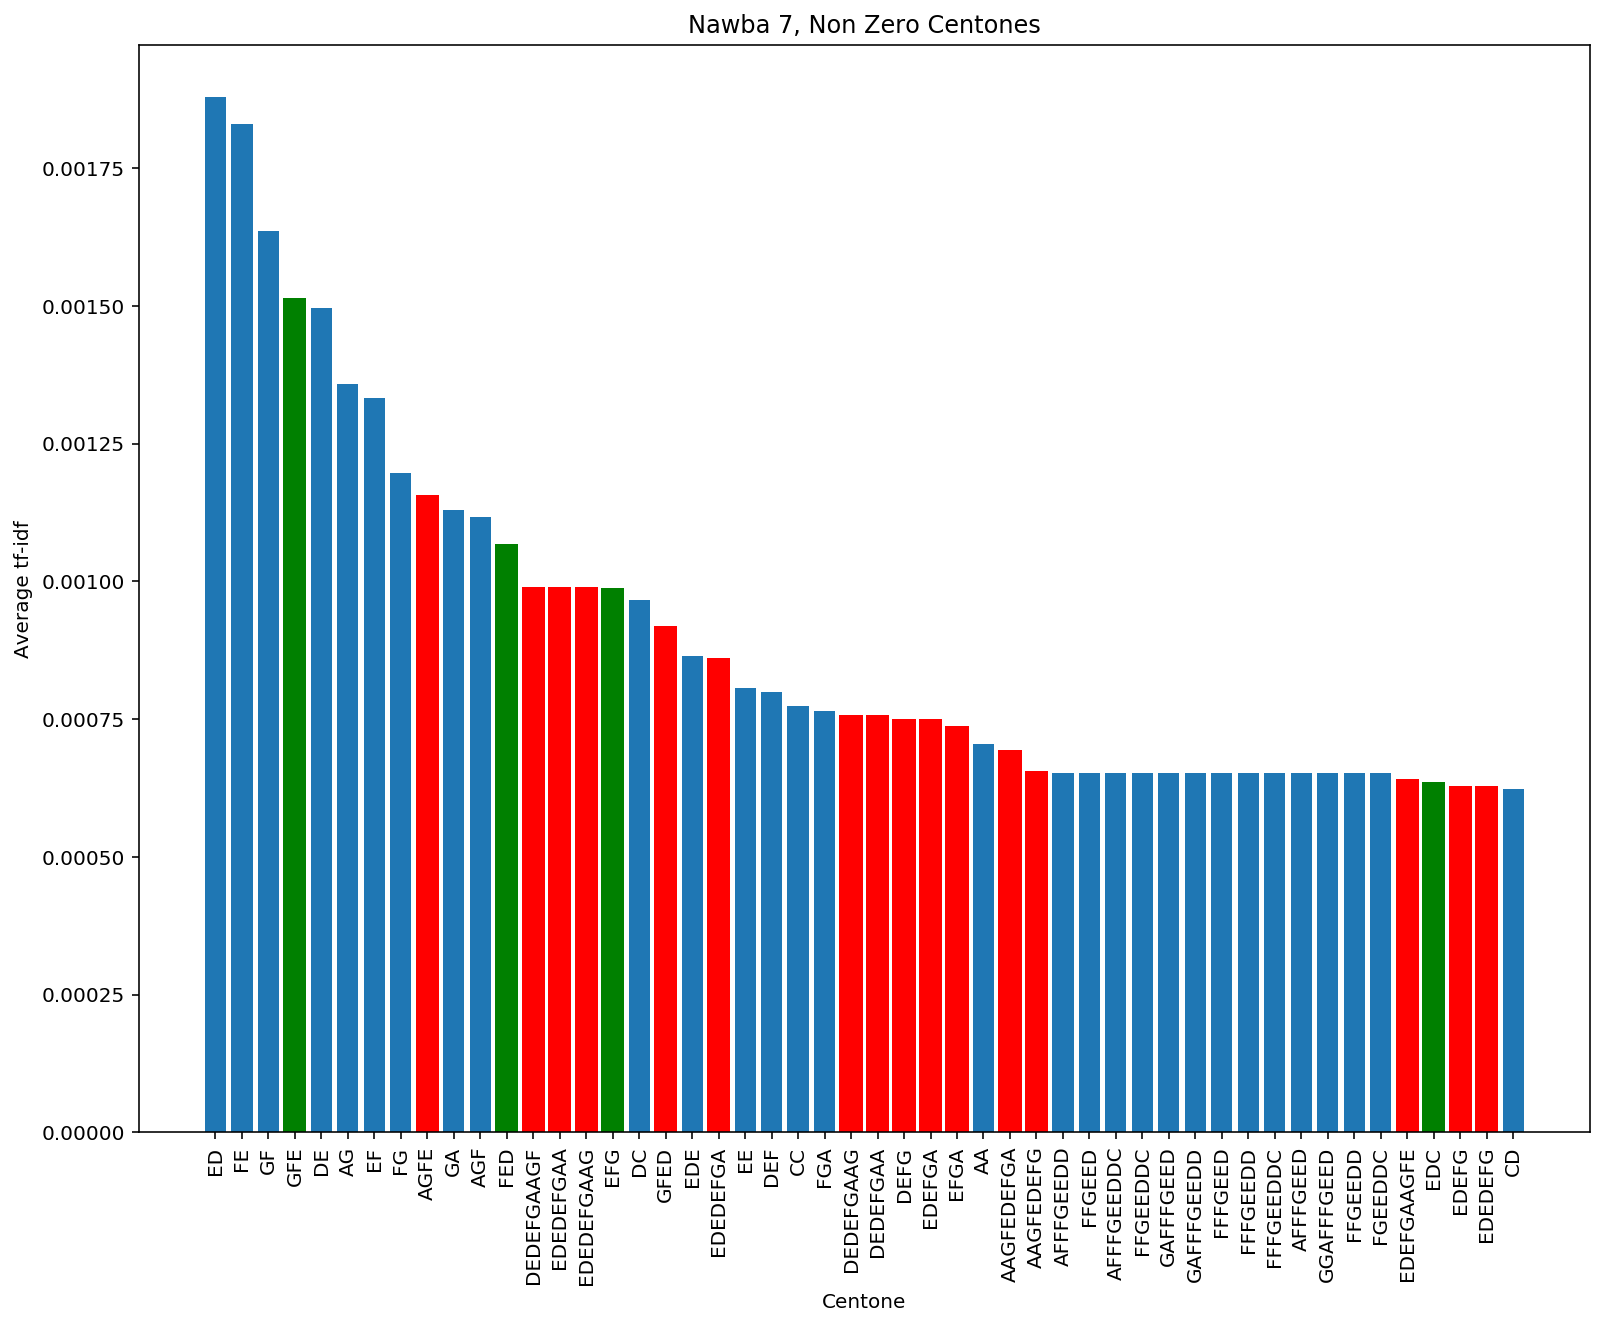

In [43]:
# Bars marked green match amins centones
# Bars marked red are supersets of amins centones
# Bars marked blues are un defined centones
nawba = 'Nawba_{}'.format(i)
reporting.get_top_centones_plot(frame_grouped, nawba, nawba_centones, n=50)
i += 1
if i > len(set(nawba_centones.keys())):
    i = 1

### Adding new centones to the Nawba_centones dictionary

In [61]:
for nawba in nawba_centones:
    this_frame = frame_grouped[(frame_grouped['index'] == nawba)].sort_values(by='tf-idf', ascending=False)
    likely_patterns = this_frame[['pattern','tf-idf']]
    likely_patterns = likely_patterns.values.tolist()
    new_centones = [x[0] for x in likely_patterns[:model.look_for_knee(likely_patterns)+1]]
    nawba_centones[nawba]= nawba_centones[nawba]+new_centones

### Applying again the Grount Truth Algorithm

In [62]:
df_predicted_nawba=[]
for mbid in notes_dict:
    predicted = model.count_centones(mbid,notes_dict,nawba_centones)
    df_predicted_nawba.append({'mbid': mbid, 'annotated': nawba_mbid_lookup[mbid], 'predicted': predicted})

df_predicted_nawba= pd.DataFrame(df_predicted_nawba)
df_predicted_nawba= df_predicted_nawba[['mbid','annotated','predicted']]

The tab with the most number of characteristics centones and the annotations matched in:  36.241610738255034 %


<module 'matplotlib.pyplot' from '/home/miguelgc96/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

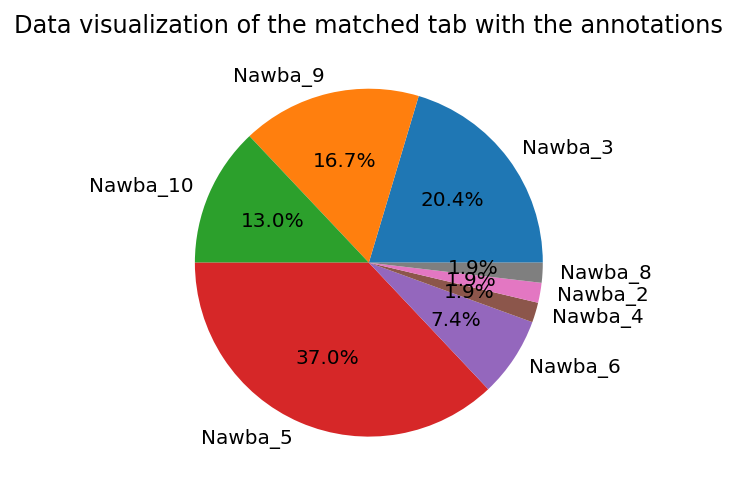

In [63]:
reporting.plot_centones_per_nawba(df_predicted_nawba)

<module 'matplotlib.pyplot' from '/home/miguelgc96/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

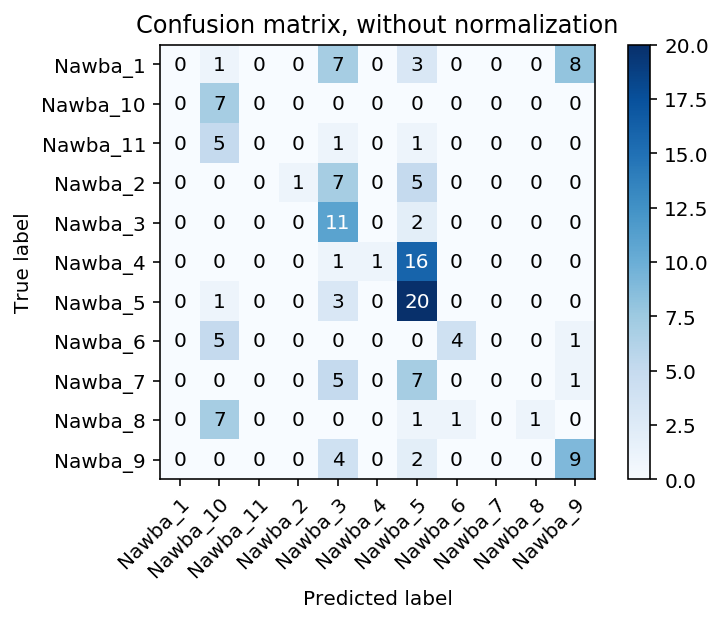

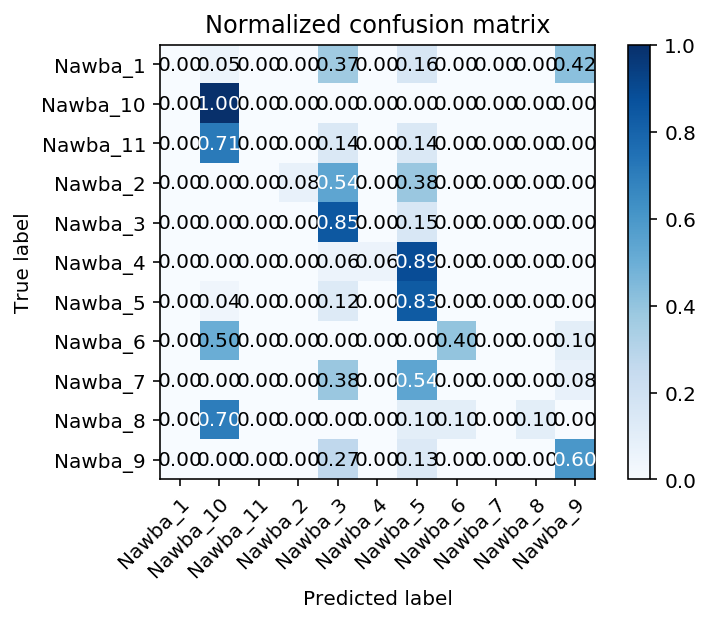

In [64]:
annotated = df_predicted_nawba['annotated'].tolist()
predicted = df_predicted_nawba['predicted'].tolist()
np.set_printoptions(precision=2)

reporting.plot_confusion_matrix(annotated, predicted,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
reporting.plot_confusion_matrix(annotated, predicted, normalize=True,
                      title='Normalized confusion matrix')